             Anomaly Detection using Unsupervised Methods in wood category of MVTec dataset

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ParameterGrid 
import warnings
import time
warnings.filterwarnings("ignore")

# Function to load MVTec images from a specific folder structure
def load_mvtec_images(path, size=(128, 128), color=True):
    images = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    if color:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    else:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, size)
                    images.append(img)
    return np.array(images)

# Load data for a given category in an unsupervised manner
def load_data(category, dataset_root='dataset/MVTec'):
    category_path = os.path.join(dataset_root, category)
    train_good_path = os.path.join(category_path, 'train', 'good')
    test_path = os.path.join(category_path, 'test')
    # Load normal images from train/good
    print(f"Loading normal images from {train_good_path}...")
    train_normal_images = load_mvtec_images(train_good_path)
    print(f"Loaded {len(train_normal_images)} normal images from {train_good_path}")
    # Load all images from test folder
    test_images = []
    test_labels = []
    for subfolder in os.listdir(test_path):
        subfolder_path = os.path.join(test_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = 0 if subfolder == 'good' else 1
            print(f"Loading images from {subfolder_path}...")
            images = load_mvtec_images(subfolder_path)
            test_images.append(images)
            test_labels.append(np.full(images.shape[0], label))
            print(f"Loaded {images.shape[0]} images from {subfolder_path}")
    test_images = np.concatenate(test_images)
    test_labels = np.concatenate(test_labels).reshape(-1, 1)
    print(f"Total normal images loaded for training: {len(train_normal_images)}")
    print(f"Total images loaded for testing: {len(test_images)}")
    return train_normal_images, test_images, test_labels

# Just Change the category [wood, pill, screw, bottle, grid] that you want to train the model, Default is "wood"

category = 'wood'
train_images, test_images, test_labels = load_data(category)

Loading normal images from dataset/MVTec\wood\train\good...
Loaded 247 normal images from dataset/MVTec\wood\train\good
Loading images from dataset/MVTec\wood\test\color...
Loaded 8 images from dataset/MVTec\wood\test\color
Loading images from dataset/MVTec\wood\test\combined...
Loaded 11 images from dataset/MVTec\wood\test\combined
Loading images from dataset/MVTec\wood\test\good...
Loaded 19 images from dataset/MVTec\wood\test\good
Loading images from dataset/MVTec\wood\test\hole...
Loaded 10 images from dataset/MVTec\wood\test\hole
Loading images from dataset/MVTec\wood\test\liquid...
Loaded 10 images from dataset/MVTec\wood\test\liquid
Loading images from dataset/MVTec\wood\test\scratch...
Loaded 21 images from dataset/MVTec\wood\test\scratch
Total normal images loaded for training: 247
Total images loaded for testing: 79


In [26]:
# Shuffle training data
def shuffle_data(data):
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    return data[idx]

train_images = shuffle_data(train_images)
test_images = shuffle_data(test_images)
test_labels = shuffle_data(test_labels)



In [27]:
# HOG Feature Extraction
def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Resize image to 128x128
        resized_image = cv2.resize(gray_image, (128, 128))
        
        # Extract HOG features
        fd, _ = hog(resized_image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)
        hog_features.append(fd)
    return np.array(hog_features)

# Extract HOG features for training and testing images
train_images_hog = extract_hog_features(train_images)
test_images_hog = extract_hog_features(test_images)


print("\nExtracted features data shapes:")
print("Train images HOG:", train_images_hog.shape)
print("Test images HOG:", test_images_hog.shape)




Extracted features data shapes:
Train images HOG: (247, 512)
Test images HOG: (79, 512)


In [28]:
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms
from torchvision.models import VGG16_Weights

# Initialing compute device (use GPU if available).
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Normalization parameters for VGG16
normalization_std = [0.229, 0.224, 0.225]
normalization_mean = [0.485, 0.456, 0.406]

# Image preprocessing
loader = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(128),
    transforms.Normalize(mean=normalization_mean, std=normalization_std)
])

# PyTorch VGG16 Feature Extraction
def extract_vgg16_features(images):
    model = models.vgg16(weights=VGG16_Weights).features.to(device)
    vgg16_features = []
    for image in images:
        img = loader(image).unsqueeze(0).to(device)
        feature = model(img).data.detach().cpu().numpy().flatten()
        vgg16_features.append(feature)
    return np.array(vgg16_features)

# Extract VGG16 features for both normal and anomalous images
train_images_vgg16 = extract_vgg16_features(train_images)
test_images_vgg16 = extract_vgg16_features(test_images)

# Print the extracted features by VGG16
print("\nExtracted features data shapes:")
print("Extracted_features_of_train_images_vgg16:", train_images_vgg16.shape)
print("Extracted_features_of_test_images_vgg16:", test_images_vgg16.shape)


Extracted features data shapes:
Extracted_features_of_train_images_vgg16: (247, 8192)
Extracted_features_of_test_images_vgg16: (79, 8192)


In [29]:

# Normalize data
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

normalized_train_images = min_max_scaling(train_images_hog)
normalized_test_images = min_max_scaling(test_images_hog)

normalized_train_images_vgg16 = min_max_scaling(train_images_vgg16)
normalized_test_images_vgg16 = min_max_scaling(test_images_vgg16)

print("\nNormalized features of hog data shapes:")
print("Normalized train images of HOG:", normalized_train_images.shape)
print("Normalized test images of HOG:", normalized_test_images.shape)


print("\nNormalized features of VGG16 data shapes:")
print("normalized train_images using VGG16:", normalized_train_images_vgg16.shape)
print("normalized test_images using VGG16:", normalized_test_images_vgg16.shape)



Normalized features of hog data shapes:
Normalized train images of HOG: (247, 512)
Normalized test images of HOG: (79, 512)

Normalized features of VGG16 data shapes:
normalized train_images using VGG16: (247, 8192)
normalized test_images using VGG16: (79, 8192)


In [30]:
# Dimensionality reduction using PCA
def PCA(train_data, alpha=0.95):
    mean = np.mean(train_data, axis=0)
    centered_data = train_data - mean
    cov_matrix = np.dot(centered_data.T, centered_data)
    eig_values, eig_vectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eig_values)[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]
    total = np.sum(eig_values)
    k = 0
    var = 0
    while var / total < alpha:
        var += eig_values[k]
        k += 1
    eig_vectors = eig_vectors[:, :k]
    return eig_vectors, mean

# Apply PCA on normalized training data
pca_components, mean = PCA(normalized_train_images)

# Project the normalized training and testing data onto the PCA components
train_projected_pca = np.dot(normalized_train_images - mean, pca_components)
test_projected_pca = np.dot(normalized_test_images - mean, pca_components)
print(f"\nPCA - Number of components retained: {pca_components.shape[1]}")

print("\nProjected data shapes after PCA:")
print("Projected train images:", train_projected_pca.shape)
print("Projected test images:", test_projected_pca.shape)


# Perform PCA on VGG16 features
space_pca_vgg16, mean_pca_vgg16 = PCA(normalized_train_images_vgg16)
train_projected_pca_vgg16 = np.dot(normalized_train_images_vgg16 - mean_pca_vgg16, space_pca_vgg16)
test_projected_pca_vgg16 = np.dot(normalized_test_images_vgg16 - mean_pca_vgg16, space_pca_vgg16)

print("\nReduction features of VGG16 data shapes:")
print("Reduction_train_images_PCA:", train_projected_pca_vgg16.shape)
print("Reduction_test_images_PCA:", test_projected_pca_vgg16.shape)



PCA - Number of components retained: 153

Projected data shapes after PCA:
Projected train images: (247, 153)
Projected test images: (79, 153)

Reduction features of VGG16 data shapes:
Reduction_train_images_PCA: (247, 133)
Reduction_test_images_PCA: (79, 133)


In [31]:
# Custom implementation of K-Means with convergence iteration tracking
def k_means(X, n_clusters, max_iters=100, tol=1e-4):
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, n_clusters, replace=False)]
    centroid_history = [centroids.copy()]  # Track centroid history
    for iter_ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(n_clusters)])
        centroid_history.append(new_centroids.copy())  # Track new centroids
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return labels, centroids, iter_ + 1, centroid_history


With Out PCA (HOG) - DBSCAN
Testing Accuracy: 75.9494
F1 Score: 0.4317
Best Hyperparameters: {'eps': 0.1, 'min_samples': 5}


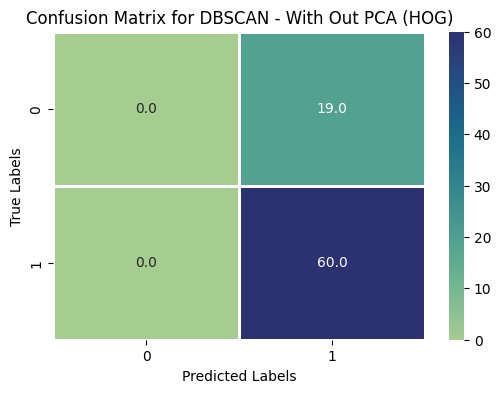

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.76      1.00      0.86        60

    accuracy                           0.76        79
   macro avg       0.38      0.50      0.43        79
weighted avg       0.58      0.76      0.66        79

------------------------------------------------------------------------------------------------------------------------
With PCA (HOG) - DBSCAN
Testing Accuracy: 75.9494
F1 Score: 0.4317
Best Hyperparameters: {'eps': 0.1, 'min_samples': 5}


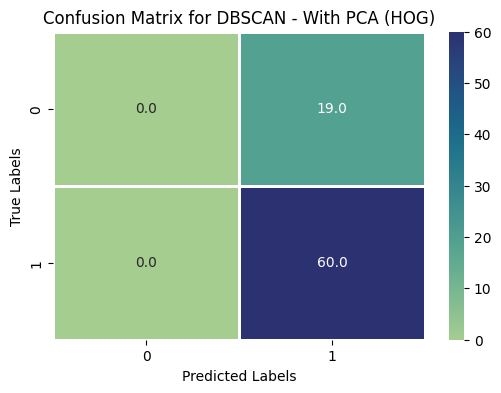

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.76      1.00      0.86        60

    accuracy                           0.76        79
   macro avg       0.38      0.50      0.43        79
weighted avg       0.58      0.76      0.66        79

------------------------------------------------------------------------------------------------------------------------
With Out PCA (HOG) - Gaussian Mixture Model
Testing Accuracy: 34.1772
F1 Score: 0.3366
Best Hyperparameters: {}


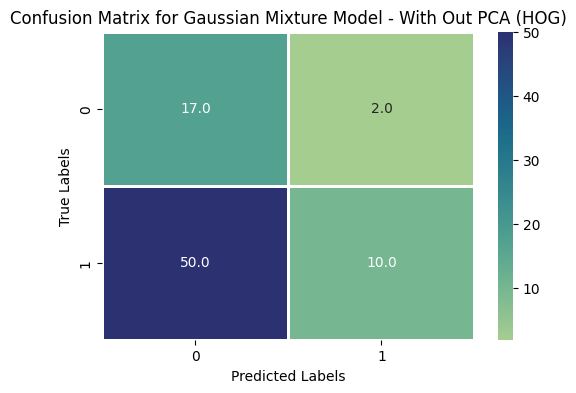

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.89      0.40        19
           1       0.83      0.17      0.28        60

    accuracy                           0.34        79
   macro avg       0.54      0.53      0.34        79
weighted avg       0.69      0.34      0.31        79

------------------------------------------------------------------------------------------------------------------------
With PCA (HOG) - Gaussian Mixture Model
Testing Accuracy: 75.9494
F1 Score: 0.4317
Best Hyperparameters: {}


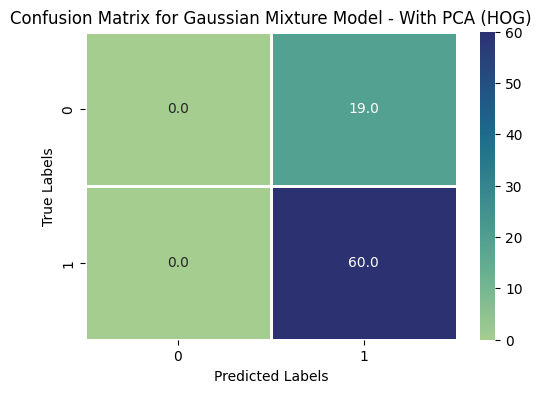

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.76      1.00      0.86        60

    accuracy                           0.76        79
   macro avg       0.38      0.50      0.43        79
weighted avg       0.58      0.76      0.66        79

------------------------------------------------------------------------------------------------------------------------
With Out PCA (HOG) - K-Means
Testing Accuracy: 51.8987
F1 Score: 0.4895
Best Hyperparameters: {}


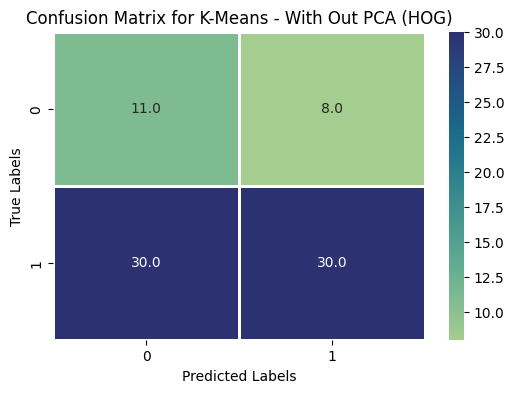

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.58      0.37        19
           1       0.79      0.50      0.61        60

    accuracy                           0.52        79
   macro avg       0.53      0.54      0.49        79
weighted avg       0.66      0.52      0.55        79

------------------------------------------------------------------------------------------------------------------------
With PCA (HOG) - K-Means
Testing Accuracy: 48.1013
F1 Score: 0.4374
Best Hyperparameters: {}


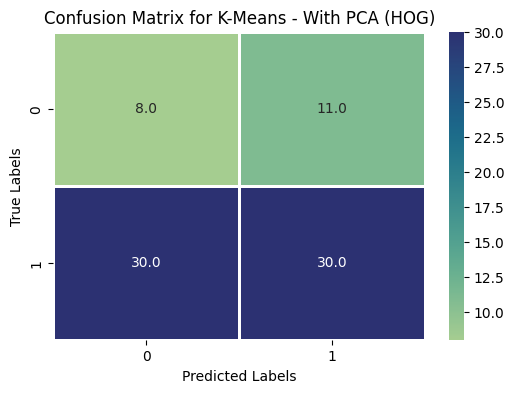

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.42      0.28        19
           1       0.73      0.50      0.59        60

    accuracy                           0.48        79
   macro avg       0.47      0.46      0.44        79
weighted avg       0.61      0.48      0.52        79

------------------------------------------------------------------------------------------------------------------------

The Best model is: K-Means with With Out PCA method, having an F1 score of 0.4895
Hyperparameters: {}


With Out PCA (VGG16) - DBSCAN
Testing Accuracy: 75.9494
F1 Score: 0.4317
Best Hyperparameters: {'eps': 0.1, 'min_samples': 5}


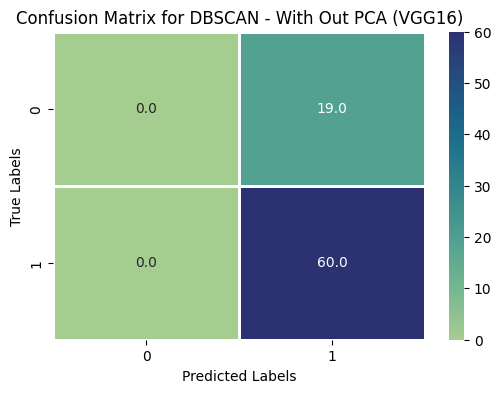

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.76      1.00      0.86        60

    accuracy                           0.76        79
   macro avg       0.38      0.50      0.43        79
weighted avg       0.58      0.76      0.66        79

------------------------------------------------------------------------------------------------------------------------
With PCA (VGG16) - DBSCAN
Testing Accuracy: 75.9494
F1 Score: 0.4317
Best Hyperparameters: {'eps': 0.1, 'min_samples': 5}


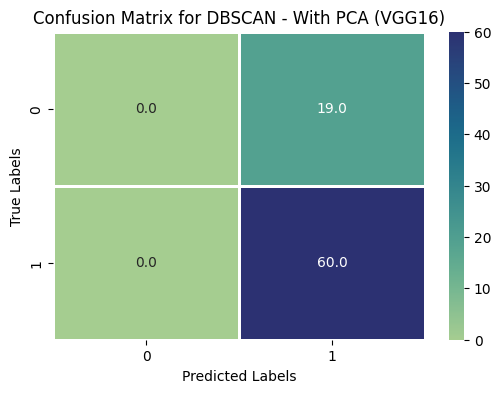

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.76      1.00      0.86        60

    accuracy                           0.76        79
   macro avg       0.38      0.50      0.43        79
weighted avg       0.58      0.76      0.66        79

------------------------------------------------------------------------------------------------------------------------
With Out PCA (VGG16) - Gaussian Mixture Model
Testing Accuracy: 26.5823
F1 Score: 0.2648
Best Hyperparameters: {}


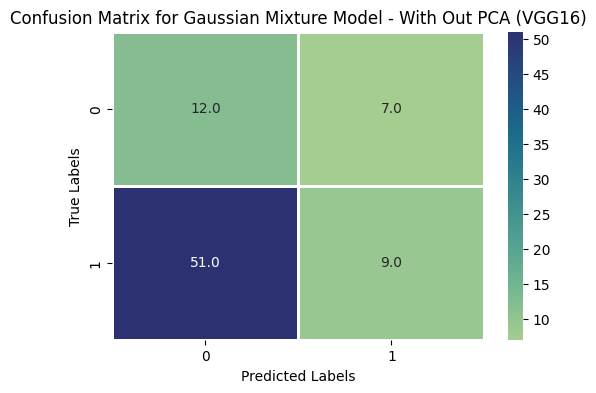

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.63      0.29        19
           1       0.56      0.15      0.24        60

    accuracy                           0.27        79
   macro avg       0.38      0.39      0.26        79
weighted avg       0.47      0.27      0.25        79

------------------------------------------------------------------------------------------------------------------------
With PCA (VGG16) - Gaussian Mixture Model
Testing Accuracy: 24.0506
F1 Score: 0.1939
Best Hyperparameters: {}


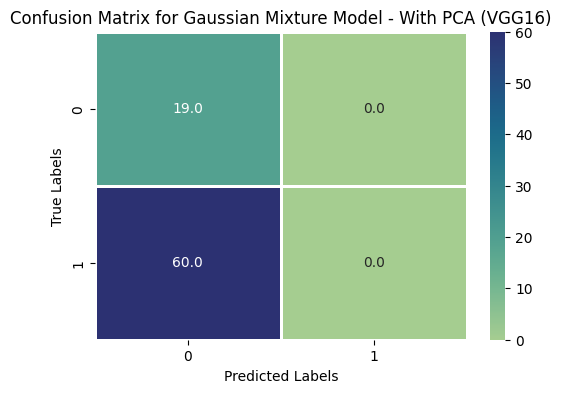

Classification Report:
              precision    recall  f1-score   support

           0       0.24      1.00      0.39        19
           1       0.00      0.00      0.00        60

    accuracy                           0.24        79
   macro avg       0.12      0.50      0.19        79
weighted avg       0.06      0.24      0.09        79

------------------------------------------------------------------------------------------------------------------------
With Out PCA (VGG16) - K-Means
Testing Accuracy: 64.5570
F1 Score: 0.5314
Best Hyperparameters: {}


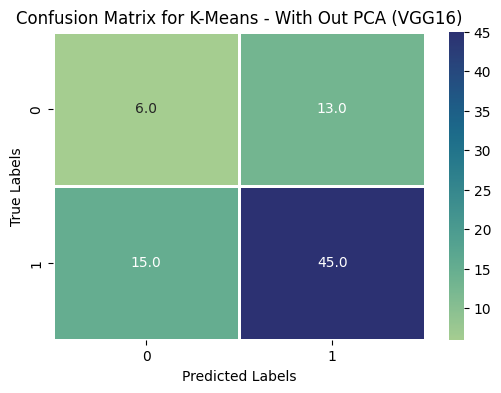

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.32      0.30        19
           1       0.78      0.75      0.76        60

    accuracy                           0.65        79
   macro avg       0.53      0.53      0.53        79
weighted avg       0.66      0.65      0.65        79

------------------------------------------------------------------------------------------------------------------------
With PCA (VGG16) - K-Means
Testing Accuracy: 64.5570
F1 Score: 0.5314
Best Hyperparameters: {}


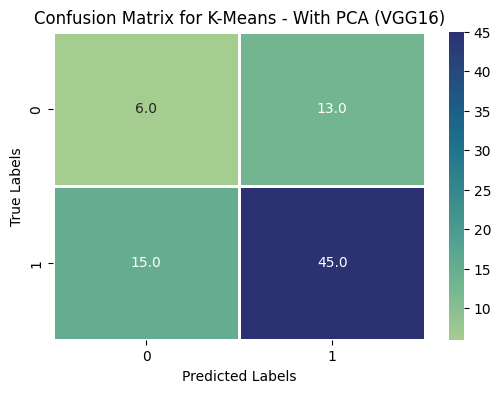

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.32      0.30        19
           1       0.78      0.75      0.76        60

    accuracy                           0.65        79
   macro avg       0.53      0.53      0.53        79
weighted avg       0.66      0.65      0.65        79

------------------------------------------------------------------------------------------------------------------------

The Best model is: K-Means with With Out PCA (VGG16) method, having an F1 score of 0.5314
Hyperparameters: {}




In [32]:

classifiers = [
    ("DBSCAN", DBSCAN(), {'eps': [0.1, 0.5, 1], 'min_samples': [5, 10, 20]}),
    ("Gaussian Mixture Model", GaussianMixture(n_components=2), {}),  
    ("K-Means", KMeans(n_clusters=2), {})  
    
]

# Initialize lists to store classifier names, training accuracies, test accuracies, and F1-scores
classifier_names = []
test_accuracies = []
f1_scores = []
hyperparameters = []

X_for_training = [normalized_train_images, train_projected_pca]
X_for_test = [normalized_test_images, test_projected_pca]

X_for_training_vgg16 = [normalized_train_images_vgg16, train_projected_pca_vgg16]
X_for_test_vgg16 = [normalized_test_images_vgg16, test_projected_pca_vgg16]


text = ['With Out PCA', 'With PCA']

# Function to perform hyperparameter tuning and evaluation
def evaluate_classifier(name, classifier, param_grid, X_train, X_test, y_test, feature_text):
    # Hyperparameter tuning
    best_params = None
    best_score = -1
    for params in ParameterGrid(param_grid):
        classifier.set_params(**params)
        if isinstance(classifier, GaussianMixture):
            classifier.fit(X_train)
            predictions = classifier.predict(X_train)
            predictions = np.where(predictions == 0, 1, 0)  # Treat one cluster as anomaly (1) and other as normal (0)
        elif isinstance(classifier, KMeans):
            classifier.fit(X_train)
            predictions = classifier.predict(X_train)
            predictions = np.where(predictions == 0, 1, 0)  # Treat one cluster as anomaly (1) and other as normal (0)
        elif isinstance(classifier, DBSCAN):
            classifier.fit(X_train)
            predictions = classifier.fit_predict(X_train)
            predictions = np.where(predictions == -1, 1, 0)  # Treat -1 as anomaly (1) and other labels as normal (0)
        elif isinstance(classifier, MeanShift):
            classifier.fit(X_train)
            predictions = classifier.predict(X_train)
            predictions = np.where(predictions == 0, 1, 0)  # Treat one cluster as anomaly (1) and other as normal (0)
        else:
            classifier.fit(X_train)
            predictions = classifier.predict(X_train)
        score = f1_score(np.ones_like(predictions), predictions, average='macro')
        if score > best_score:
            best_params = params
            best_score = score
    classifier.set_params(**best_params)
    
    # Evaluate on test data
    if isinstance(classifier, GaussianMixture):
        predictions = classifier.predict(X_test)
        predictions = np.where(predictions == 0, 1, 0)  # Treat one cluster as anomaly (1) and other as normal (0)
    elif isinstance(classifier, KMeans):
        predictions = classifier.predict(X_test)
        predictions = np.where(predictions == 0, 1, 0)  # Treat one cluster as anomaly (1) and other as normal (0)
    elif isinstance(classifier, DBSCAN):
        predictions = classifier.fit_predict(X_test)
        predictions = np.where(predictions == -1, 1, 0)  # Treat -1 as anomaly (1) and other labels as normal (0)
    elif isinstance(classifier, MeanShift):
        predictions = classifier.predict(X_test)
        predictions = np.where(predictions == 0, 1, 0)  # Treat one cluster as anomaly (1) and other as normal (0)
    else:
        predictions = classifier.predict(X_test)
        predictions = np.where(predictions == 1, 0, 1)  # Treat 1 as normal (0) and -1 as anomaly (1)
    
    test_score = accuracy_score(y_test, predictions)
    current_f1_score = f1_score(y_test, predictions, average='macro')
    
    # Print the results
    print(f"{feature_text} - {name}")
    print(f"Testing Accuracy: {test_score * 100:.4f}")
    print(f"F1 Score: {current_f1_score:.4f}")
    print(f"Best Hyperparameters: {best_params}")
    
    # Plot the confusion matrix
    conmat = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conmat, annot=True, fmt=".1f", linewidth=1, cmap="crest")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {name} - {feature_text}")
    plt.show()
    
    # Print the classification report
    class_report = classification_report(y_test, predictions)
    print("Classification Report:")
    print(class_report)
    print("-" * 120)
    
    # Append results to lists
    classifier_names.append(name)
    test_accuracies.append(test_score)
    f1_scores.append(current_f1_score)
    hyperparameters.append(str(best_params))

# Evaluate classifiers
for name, classifier, param_grid in classifiers:
    for i in range(len(text)):
        evaluate_classifier(name, classifier, param_grid, X_for_training[i], X_for_test[i], test_labels, f"{text[i]} (HOG)")

# Print the best model information
best_model_info = {'name': None, 'feature_extraction': None, 'f1_score': 0, 'hyperparameters': None}
for name, feature_extraction, f1, params in zip(classifier_names, [text[i % len(text)] for i in range(len(classifier_names))], f1_scores, hyperparameters):
    if f1 > best_model_info['f1_score']:
        best_model_info['name'] = name
        best_model_info['feature_extraction'] = feature_extraction
        best_model_info['f1_score'] = f1
        best_model_info['hyperparameters'] = params
print(f"\nThe Best model is: {best_model_info['name']} with {best_model_info['feature_extraction']} method, having an F1 score of {best_model_info['f1_score']:.4f}")
print(f"Hyperparameters: {best_model_info['hyperparameters']}\n\n")


# Evaluate classifiers for VGG16 features
for name, classifier, param_grid in classifiers:
    for i in range(len(text)):
        evaluate_classifier(name, classifier, param_grid, X_for_training_vgg16[i], X_for_test_vgg16[i], test_labels, f"{text[i]} (VGG16)")

# Print the best model information (including VGG16)
best_model_info = {'name': None, 'feature_extraction': None, 'f1_score': 0, 'hyperparameters': None}
for name, feature_extraction, f1, params in zip(classifier_names, [f"{text[i % len(text)]} ({('VGG16' if i >= len(text) else '')})" for i in range(len(classifier_names))], f1_scores, hyperparameters):
    if f1 > best_model_info['f1_score']:
        best_model_info['name'] = name
        best_model_info['feature_extraction'] = feature_extraction
        best_model_info['f1_score'] = f1
        best_model_info['hyperparameters'] = params

print(f"\nThe Best model is: {best_model_info['name']} with {best_model_info['feature_extraction']} method, having an F1 score of {best_model_info['f1_score']:.4f}")
print(f"Hyperparameters: {best_model_info['hyperparameters']}\n\n")

